Imports & Setting up Environment

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

mixed_precision.set_global_policy('mixed_float16')

tf.get_logger().setLevel("ERROR")
tf.config.optimizer.set_jit(True)

Grabbing Data & Checking Ranges

In [ ]:
IMAGE_SIZE = [380, 380]
BATCH_SIZE = 12
AUTO = tf.data.experimental.AUTOTUNE
TRAIN_DIR = 'Datasets/Training'
TEST_DIR = 'Datasets/Testing'

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split = 0.15,
    subset = "training",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split = 0.15,
    subset = "validation",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True
)

testing_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True
)





In [3]:
class_names = train_ds.class_names

print(class_names)

images, labels = next(iter(train_ds))

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

print("Pixel min:", tf.reduce_min(images).numpy())
print("Pixel max:", tf.reduce_max(images).numpy())

['glioma', 'meningioma', 'notumor', 'pituitary']
Images shape: (12, 380, 380, 3)
Labels shape: (12,)
Pixel min: 0.0
Pixel max: 255.0


Applying Data Augments & Preprocessing Data

In [4]:
def data_augment_batch(images, labels):
    images = tf.image.random_flip_left_right(images) #These methods allow whole batches to be augmented
    #instead of needing to unpack
    
    images = tf.image.random_flip_up_down(images)
    images = preprocess_input(images)
    return images, labels

def preprocess_only(images, labels):
    images = preprocess_input(images)
    return images, labels

In [5]:
train_ds = train_ds.map(data_augment_batch, num_parallel_calls=2)
train_ds = train_ds.shuffle(512) #Shuffle batches
train_ds = train_ds.prefetch(3) #Fetch the next 3 batches

val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTO).prefetch(3)
testing_ds = testing_ds.map(preprocess_only, num_parallel_calls=AUTO).prefetch(3)

Load EfficientNetB4 Encoder & Create Head

In [ ]:
EPOCHS = 15

with tf.device('/gpu:0'):
    pretrained_model = tf.keras.applications.EfficientNetB4(
        weights = 'imagenet',
        include_top = False,
        input_shape = [*IMAGE_SIZE, 3]      
    )

    pretrained_model.trainable = False

from tensorflow import keras as K
from tensorflow.keras import layers as L

inputs = K.Input(shape=(380, 380, 3))
x = pretrained_model(inputs)

#Slides a small learnable filter (kernel) over the image and creates feature map that detects edges, textures, shapes, and higer-level patterns
#Second param is kernel size so 1 = 1x1. Each filter learns to detect something different
x = L.Conv2D(128, 1, padding = 'same', use_bias=False)(x) 
#Keeps the activations from exploding or vanishinng, making trainer faster, more stable, and allowing higher learning rates
x = L.BatchNormalization()(x)
x = L.ReLU()(x)

x = L.Conv2D(128, 3, padding = 'same', use_bias=False)(x) 
#Keeps the activations from exploding or vanishinng, making trainer faster, more stable, and allowing higher learning rates
x = L.BatchNormalization()(x)
x = L.ReLU()(x)

x = L.Conv2D(128, 3, padding = 'same', use_bias=False)(x) 
#Keeps the activations from exploding or vanishinng, making trainer faster, more stable, and allowing higher learning rates
x = L.BatchNormalization()(x)
x = L.ReLU()(x)

x = L.Conv2D(64, 1, padding = 'same', use_bias=False)(x)
x = L.BatchNormalization()(x)
x = L.ReLU()(x)

x = L.GlobalAveragePooling2D()(x)
x = L.Dropout(0.3)(x)

outputs = L.Dense(len(class_names), activation='softmax', dtype='float32')(x)

model = K.Model(inputs, outputs)

In [7]:
for layer in pretrained_model.layers:
    layer.trainable = False

model.compile(
    optimizer=K.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 128)    │       229,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,208,355 (69.46 MB)

 Trainable params: 533,636 (2.04 MB)

 Non-trainable params: 17,674,719 (67.42 MB)

Training With Backbone Frozen

In [ ]:
from tensorflow.keras.callbacks import Callback
from tqdm.auto import tqdm


class TQDMBar(Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.params['epochs'])
    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
    def on_train_end(self, logs=None):
        self.pbar.close()



cbs = [
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #Watch val_loss
                                       factor=0.5, #when plateauing, multiply LR by 0.5
                                       patience=2, #wait 2 epochs of no val_loss improvement before reducing LR
                                       min_lr=5e-6, 
                                       verbose=1),
  tf.keras.callbacks.EarlyStopping(
                                  monitor='val_loss', #Stop based on validation loss
                                   patience=4, #stop if no improvement for 4 epochs
                                   restore_best_weights=True 
                                  ),
  tf.keras.callbacks.ModelCheckpoint(
      'best1.keras', 
      monitor='val_loss', #pick best by lowest validation loss
      save_best_only=True #only overwrite file when val_loss improves
  )
]

#all Callbacks combined
all_callbacks = cbs + [TQDMBar()]


history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=EPOCHS, 
    callbacks=all_callbacks
)

Training With Last 100 Layers of Backbone Unfrozen

In [ ]:
FT_EPOCHS = 12


# ---- steps/epoch for cosine schedule ----
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()

# Handle special cardinality values
if steps_per_epoch == tf.data.experimental.INFINITE_CARDINALITY:
    raise ValueError("train_ds has infinite cardinality; cannot infer steps_per_epoch.")
if steps_per_epoch < 0:
    raise ValueError(
        "train_ds cardinality is UNKNOWN. "
        "Compute steps_per_epoch manually as ceil(num_train_examples / BATCH_SIZE)."
    )

total_decay_steps = steps_per_epoch * FT_EPOCHS
print("steps_per_epoch:", steps_per_epoch)
print("total_decay_steps:", total_decay_steps)

pretrained_model.trainable = True

for layer in pretrained_model.layers:
    layer.trainable = False

for layer in pretrained_model.layers[-100:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


lr0 = 1e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr0,
    decay_steps=total_decay_steps,
    alpha=0.05,  # ends at 5% of lr0
)



model.compile(
    optimizer=K.optimizers.Adam(lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()


cbs2 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_stage3.keras", monitor="val_loss", save_best_only=True),
    TQDMBar(),
]

#continue from stage 1 training
initial_epoch = len(history.history["loss"])
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epoch + FT_EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=cbs2,
)


Display Model Loss, Accuracy, and Confusion Matrix

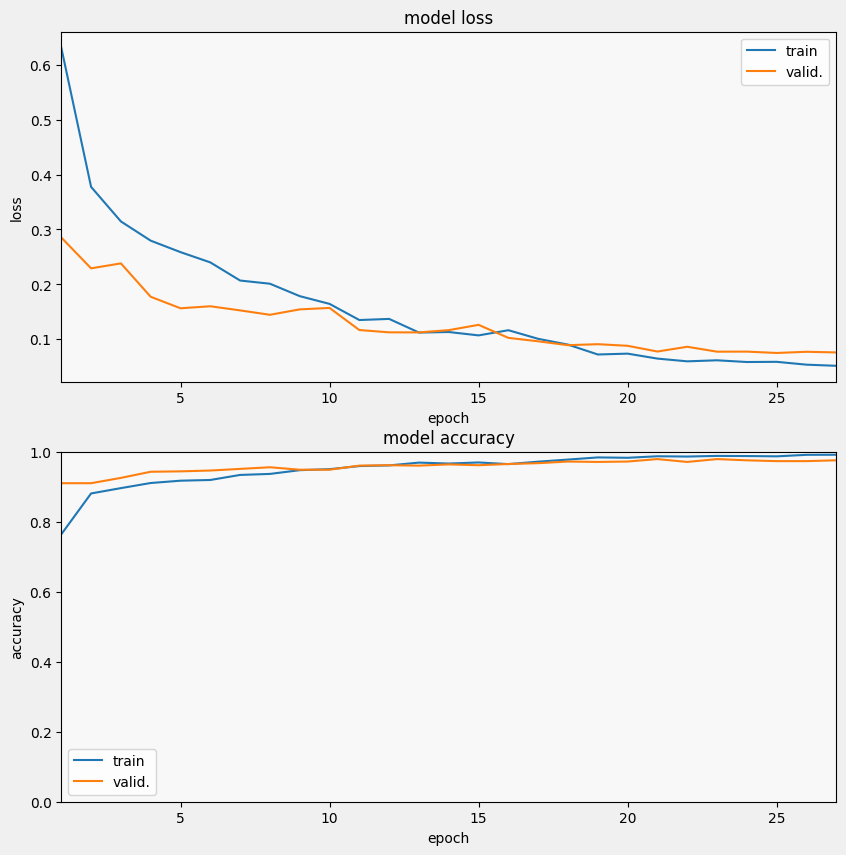

In [11]:



def display_training_curves(training, validation, title, subplot, fix_ylim=False):
    if subplot % 10 == 1:
        plt.figure(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()

    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')

    epochs = np.arange(1, len(training) + 1)
    ax.plot(epochs, training, label='train')
    ax.plot(epochs, validation, label='valid.')

    ax.set_title('model ' + title)
    ax.set_xlabel('epoch')
    ax.set_ylabel(title)
    ax.set_xlim(1, len(training))           

    if fix_ylim:                            
        ax.set_ylim(0.0, 1.0)
    ax.legend()


display_training_curves(history.history['loss'] + history2.history["loss"],
                        history.history['val_loss'] + history2.history["val_loss"],
                        'loss', 211, fix_ylim=False)

display_training_curves(history.history['sparse_categorical_accuracy'] + history2.history["sparse_categorical_accuracy"],
                        history.history['val_sparse_categorical_accuracy'] + history2.history["val_sparse_categorical_accuracy"],
                        'accuracy', 212, fix_ylim=True)


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('best_stage3.keras')

In [12]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

def display_confusion_matrix(
    cm_counts,
    cmat_norm,
    score,
    precision,
    recall,
    fig_size=(9, 9),      # <-- smaller plot (try (8,8) or (7,7))
    tick_fs=11,           # <-- class name font size
    cell_fs=12,           # <-- numbers inside each cell
    axis_fs=13,           # <-- "Predicted/True" label font size
    title_fs=14           # <-- title font size
):
    fig, ax = plt.subplots(figsize=fig_size)

    im = ax.matshow(cmat_norm, cmap="Reds")

    # Colorbar with readable ticks
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=tick_fs)

    n = cm_counts.shape[0]

    # ticks + tick labels
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(class_names, fontsize=tick_fs)
    ax.set_yticklabels(class_names, fontsize=tick_fs)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # axis labels
    ax.set_xlabel("Predicted label", fontsize=axis_fs)
    ax.set_ylabel("True label", fontsize=axis_fs)

    # cell text (count + percent)
    for i in range(n):
        for j in range(n):
            cnt = cm_counts[i, j]
            pct = cmat_norm[i, j] * 100.0
            ax.text(
                j, i, f"{cnt}\n{pct:.1f}%",
                ha="center", va="center",
                fontsize=cell_fs,
                color="white" if cmat_norm[i, j] > 0.5 else "black"
            )

    # title
    ax.set_title(
        f"F1={score:.3f}  Precision={precision:.3f}  Recall={recall:.3f}",
        fontsize=title_fs,
        pad=16
    )

    plt.tight_layout()
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

2026-01-11 16:29:47.796737: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


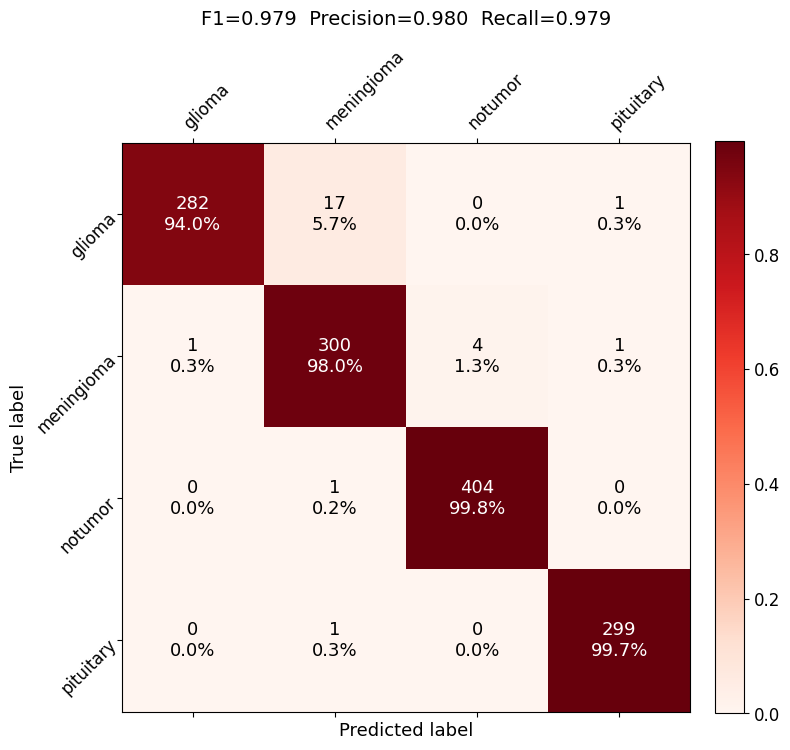

In [13]:
# number of classes
num_classes = len(class_names)
labels = np.arange(num_classes)

#
cm = np.zeros((num_classes, num_classes), dtype=np.int64)
y_true_chunks, y_pred_chunks = [], []


ds_valid_eval = testing_ds



for x, y in ds_valid_eval:
    #batched prediction
    p = model.predict(x, verbose=0)       
    preds = np.argmax(p, axis=1)       
    yt = y.numpy()                       

    #confusion matrix counts
    for t, pr in zip(yt, preds):
        cm[t, pr] += 1

    #keep labels/preds for metrics
    y_true_chunks.append(yt)
    y_pred_chunks.append(preds)

#concatenate once at the end
y_true = np.concatenate(y_true_chunks)
y_pred = np.concatenate(y_pred_chunks)

#row-normalized confusion matrix for plotting
row_sums = np.maximum(cm.sum(axis=1, keepdims=True), 1)
cmat = cm / row_sums


acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
pre = precision_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
rec = recall_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)


display_confusion_matrix(cm, cmat, f1, pre, rec, fig_size=(8,8), tick_fs=12, cell_fs=13)



In [13]:
from tensorflow.keras.models import load_model

model = load_model('best_stage3.keras')

Create Gradcam Heatmap and Overlay on Scan

In [14]:
#Grab last Conv/pooling layer for grad-map as this is the last layer that contains spatial information
last_conv_layer_name = "conv2d_1"
last_conv_layer = model.get_layer(last_conv_layer_name)
print(last_conv_layer_name, last_conv_layer.output.shape)


conv2d_1 (None, 12, 12, 128)


In [15]:
import cv2  
def make_gradcam_heatmap(img_batch, model, last_conv_layer_name, class_index=None):
    """
    img_batch: tensor or np.array of shape (1, H, W, 3) *already preprocessed*
    model: your trained model
    last_conv_layer_name: string, e.g. "conv2d_1"
    class_index: optional, int class id; if None, uses model's predicted class
    """
    # Model that maps input -> (last conv feature maps, predictions)
    #Builds new model that takes the same input as the original model
    #Returns 2 things isntead of just the final prediction, output of the last conv layer -> feature maps
    #final predicitions -> class scores
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output],
    )

    
    with tf.GradientTape() as tape: #Records all operations inside this block 
        conv_outputs, predictions = grad_model(img_batch) #Run batch images through grad_model
        if class_index is None: #If we want to explain why a specific class is performing worse, we pass it as a param
            class_index = tf.argmax(predictions[0]) #Picks the predicted class for the image
        #score for the target class
        class_channel = predictions[:, class_index]

    #Checks to see which location has the most impact on the prediction (heatmap)
    grads = tape.gradient(class_channel, conv_outputs)

    #make sure we’re in float32
    conv_outputs = tf.cast(conv_outputs[0], tf.float32)  # (Hc, Wc, C)
    grads = tf.cast(grads[0], tf.float32)                # (Hc, Wc, C)

    #global-average-pool the gradients over spatial dims
    weights = tf.reduce_mean(grads, axis=(0, 1))         # (C,)

    #weighted sum of feature maps
    cam = tf.reduce_sum(conv_outputs * weights, axis=-1)  # (Hc, Wc)

    #ReLU & normalize 0–1
    cam = tf.nn.relu(cam)
    cam /= tf.reduce_max(cam) + 1e-8

    return cam.numpy(), int(class_index.numpy())


In [16]:
#Creates image for heatmap
def show_gradcam_on_image(orig_img_pil, heatmap, alpha=0.4, cmap=cv2.COLORMAP_JET):
    # heatmap is (Hc, Wc), resize to original size
    heatmap = cv2.resize(heatmap, orig_img_pil.size)
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cmap)
    orig = np.array(orig_img_pil)

    superimposed_img = heatmap_color * alpha + orig
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()



def deprocess_for_display(img_tensor):

    img = img_tensor.numpy()

    #If it already outputs [0,1], this still keeps it in [0,1] (just scaled & clipped)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    img = (img * 255.0).astype("uint8")
    return img


    


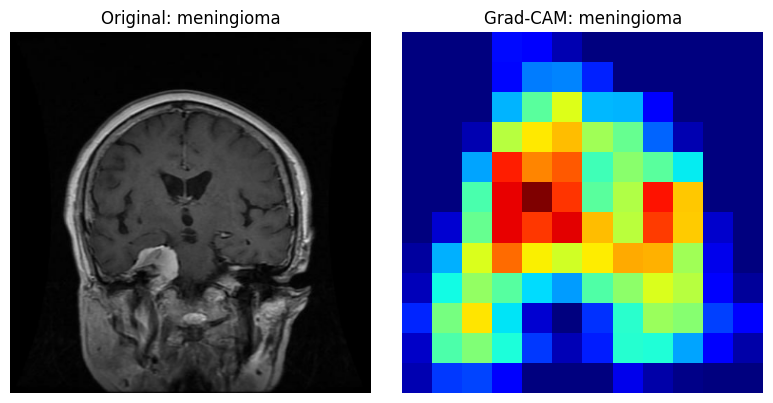

In [23]:
for batch_imgs, batch_labels in testing_ds.take(1):
    img = batch_imgs[0:1]
    true_label = int(batch_labels[0].numpy())
    break

heatmap, predicted_class = make_gradcam_heatmap(
    img, model, last_conv_layer_name="conv2d_1"
)

orig_img = deprocess_for_display(img[0])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.title(f"Original: {class_names[true_label]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap="jet")
plt.title(f"Grad-CAM: {class_names[predicted_class]}")
plt.axis("off")
plt.tight_layout()
plt.show()


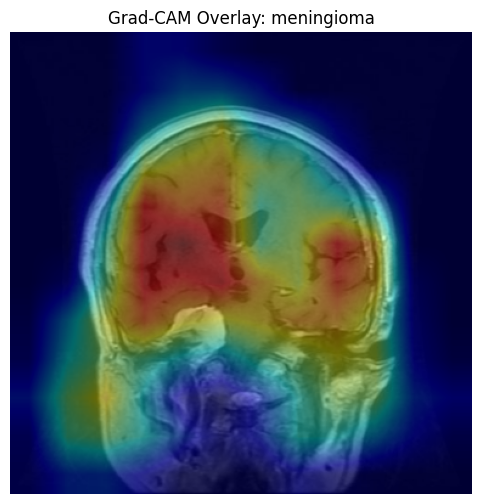

In [24]:
# If orig_img is grayscale, convert to BGR otherwise its RGB
if len(orig_img.shape) == 2 or orig_img.shape[2] == 1:
    orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)
else:
    orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)

#Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

#Apply color map (BGR)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

#Overlay in BGR space
overlay_bgr = cv2.addWeighted(orig_bgr, 0.6, heatmap_color, 0.4, 0)

#Convert BGR -> RGB for matplotlib
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(overlay_rgb)
plt.title(f"Grad-CAM Overlay: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
